# **TimeGAN**

Unofficial implementation in TensorFlow 2.

Jinsung Yoon, Daniel Jarrett, Mihaela van der Schaar, "Time-series Generative Adversarial Networks," Neural Information Processing Systems (NeurIPS), 2019.

Notebook Author: https://github.com/haufjan

### **Import of Packages**

In [28]:
import os
import time

import numpy as np
import pandas as pd

import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, mean_absolute_error

import tensorflow as tf
from tensorflow import keras

import matplotlib as mpl
import matplotlib.pyplot as plt

from tqdm import tqdm

### **Random Seeds**

In [2]:
# Random seeds
np.random.seed(42)
tf.random.set_seed(42)

### **Functions**

In [3]:
def load_dataset(file_path: str) -> np.ndarray:
    """
    Load benchmark data set from CSV file
    """
    file_path = file_path if file_path.endswith('csv') else file_path + '.csv'
    if file_path.endswith(('stock_data.csv', 'energy_data.csv')):
        # Flip data for chronological order
        benchmark_data = np.asarray(pd.read_csv(file_path))[::-1]
    else:
        rng = np.random.default_rng(seed=42)
        sine_signal = []
        for _ in range(5):
            # Randomly drawn frequency and phase
            frequency = rng.uniform(0, 0.1)
            phase = rng.uniform(0, 0.1)
            sine_signal.append([np.sin(frequency * j + phase) for j in range(10000)])

        benchmark_data = np.stack(np.transpose(np.asarray(sine_signal)))

    return benchmark_data

In [4]:
def preprocessing(data, sequence_length: int, use_scaling: bool = True, use_shuffling: bool = True, random_state: int = None) -> np.ndarray | tuple:
    """
    Conduct preprocessing: scale data, slice data into sequences and shuffle data stack

    Args:
        data: Raw input data
        sequence_length (int): Length of the sequences to be created
        use_scaling (bool): Default = True; Apply Min-Max scaling
        use_shuffling (bool): Default = True; Shuffle data stack
        random_state (int): Default = None; No random state
    Returns:
        np.ndarray | tuple: Preprocessed data stack or tuple of data stack, max values, and min values
    """
    # Minimum-Maximum scaling
    if use_scaling:
        scaler = MinMaxScaler().fit(data)
        data = scaler.transform(data)
        print('\nMaximum values:\n', scaler.data_max_, '\nMinimum values:\n', scaler.data_min_)

    # Create list of sequences defined by sequence_length and stack to a 3-dimensional array (batch, sequence_length, feature)
    data_stack = np.stack([data[i:i+sequence_length] for i in range(len(data) - sequence_length)])

    if use_shuffling:
        # In TimeGAN code the data set is mixed to make it similar to independent and identically distributed (iid)
        data_stack = shuffle(data_stack, random_state=random_state)

    return (data_stack, scaler.data_max_, scaler.data_min_) if use_scaling else data_stack

### **Load and Prepare Data**

In [5]:
# Load data set
data = load_dataset(os.path.join('stock_data'))

# Set sequence length
seq_len = 24

# Preprocess data
data_train, max_val, min_val = preprocessing(data, sequence_length=seq_len)


Maximum values:
 [1.27100000e+03 1.27389001e+03 1.24902002e+03 1.26832996e+03
 1.26832996e+03 8.27681000e+07] 
Minimum values:
 [  49.274517   50.541279   47.669952   49.681866   49.681866 7900.      ]


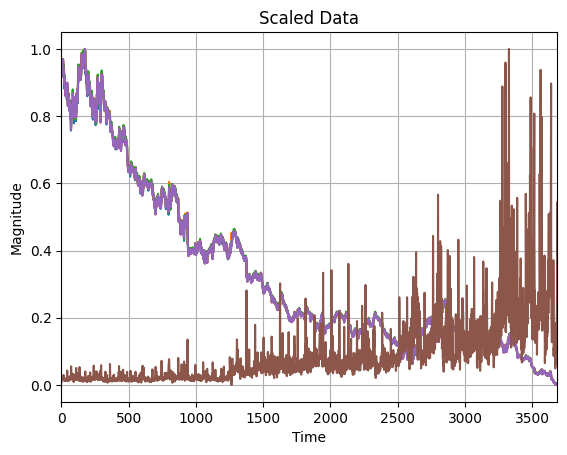

In [6]:
# Visualize scaled training data
fig, ax = plt.subplots()
ax.plot((data - min_val)/(max_val - min_val))
ax.set_xlim(0, len(data))
ax.set_xlabel('Time')
ax.set_ylabel('Magnitude')
ax.set_title('Scaled Data')
ax.grid(True)
fig.show()

### **TimeGAN Networks**

##### **Embedder**

In [7]:
class Embedder(keras.Sequential):
    def __init__(self, module_name, input_dim, hidden_dim, num_layers):
        super().__init__(name='Embedder')

        # Attributes
        self.module_name = module_name
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # Layers
        self.add(keras.Input(shape=(None, input_dim)))
        for _ in range(num_layers):
            if module_name == 'gru':
                self.add(keras.layers.GRU(units=hidden_dim, return_sequences=True))
            elif module_name == 'lstm':
                self.add(keras.layers.LSTM(units=hidden_dim, return_sequences=True))
            else:
                raise ValueError(f"Invalid module name {module_name}. Choose 'gru' or 'lstm'.")
        self.add(keras.layers.Dense(units=hidden_dim, activation='sigmoid'))

    def build(self, sequence_length: int):
        self.layers[0].input_shape = (sequence_length, self.input_dim)
        super().build()

    def call(self, x, training: bool = True):
        return super().call(x, training=training)

##### **Recovery**

In [8]:
class Recovery(keras.Sequential):
    def __init__(self, module_name, input_dim, hidden_dim, num_layers):
        super().__init__(name='Recovery')

        # Attributes
        self.module_name = module_name
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # Layers
        self.add(keras.Input(shape=(None, hidden_dim)))
        for _ in range(num_layers):
            if module_name == 'gru':
                self.add(keras.layers.GRU(units=hidden_dim, return_sequences=True))
            elif module_name == 'lstm':
                self.add(keras.layers.LSTM(units=hidden_dim, return_sequences=True))
            else:
                raise ValueError(f"Invalid module name {module_name}. Choose 'gru' or 'lstm'.")
        self.add(keras.layers.Dense(units=input_dim, activation='sigmoid'))

    def build(self, sequence_length: int):
        self.layers[0].input_shape = (sequence_length, self.hidden_dim)
        super().build()

    def call(self, x, training: bool = True):
        return super().call(x, training=training)

##### **Generator**

In [9]:
class Generator(keras.Sequential):
    def __init__(self, module_name, input_dim, hidden_dim, num_layers):
        super().__init__(name='Generator')

        # Attributes
        self.module_name = module_name
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # Layers
        self.add(keras.Input(shape=(None, input_dim)))
        for _ in range(num_layers):
            if module_name == 'gru':
                self.add(keras.layers.GRU(units=hidden_dim, return_sequences=True))
            elif module_name == 'lstm':
                self.add(keras.layers.LSTM(units=hidden_dim, return_sequences=True))
            else:
                raise ValueError(f"Invalid module name {module_name}. Choose 'gru' or 'lstm'.")
        self.add(keras.layers.Dense(units=hidden_dim, activation='sigmoid'))

    def build(self, sequence_length: int):
        self.layers[0].input_shape = (sequence_length, self.input_dim)
        super().build()

    def call(self, x, training: bool = True):
        return super().call(x, training=training)

##### **Supervisor**

In [10]:
class Supervisor(keras.Sequential):
    def __init__(self, module_name, hidden_dim, num_layers):
        super().__init__(name='Supervisor')

        # Attributes
        self.module_name = module_name
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # Layers
        self.add(keras.Input(shape=(None, hidden_dim)))
        for _ in range(num_layers):
            if module_name == 'gru':
                self.add(keras.layers.GRU(units=hidden_dim, return_sequences=True))
            elif module_name == 'lstm':
                self.add(keras.layers.LSTM(units=hidden_dim, return_sequences=True))
            else:
                raise ValueError(f"Invalid module name {module_name}. Choose 'gru' or 'lstm'.")
        self.add(keras.layers.Dense(units=hidden_dim, activation='sigmoid'))

    def build(self, sequence_length: int):
        self.layers[0].input_shape = (sequence_length, self.hidden_dim)
        super().build()

    def call(self, x, training: bool = True):
        return super().call(x, training=training)

##### **Discriminator**

In [11]:
class Discriminator(keras.Sequential):
    def __init__(self, module_name, hidden_dim, num_layers):
        super().__init__(name='Discriminator')

        # Attributes
        self.module_name = module_name
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # Layers
        self.add(keras.Input(shape=(None, hidden_dim)))
        for _ in range(num_layers):
            if module_name == 'gru':
                # Bidirectional discriminator
                self.add(keras.layers.Bidirectional(keras.layers.GRU(units=hidden_dim, return_sequences=True)))
                # Unidirectional discriminator
                # self.add(keras.layers.GRU(units=hidden_dim, return_sequences=True))
            elif module_name == 'lstm':
                # Bidirectional discriminator
                self.add(keras.layers.Bidirectional(keras.layers.LSTM(units=hidden_dim, return_sequences=True)))
                # Unidirectional discriminator
                # self.add(keras.layers.LSTM(units=hidden_dim, return_sequences=True))
            else:
                raise ValueError(f"Invalid module name {module_name}. Choose 'gru' or 'lstm'.")
        self.add(keras.layers.Dense(units=1, activation=None))

    def build(self, sequence_length: int):
        self.layers[0].input_shape = (sequence_length, self.hidden_dim)
        super().build()

    def call(self, x, training: bool = True):
        return super().call(x, training=training)

### **Loss Functions**

In [12]:
@tf.function
def embedding_loss(x, x_tilde):
    return 10*tf.math.sqrt(keras.losses.MeanSquaredError()(x, x_tilde))

In [13]:
@tf.function
def supervised_loss(h, h_hat_supervise):
    return keras.losses.MeanSquaredError()(h[:,1:,:], h_hat_supervise[:,:-1,:])

In [14]:
@tf.function
def generator_loss(y_fake, y_fake_e, h, h_hat_supervise, x, x_hat, gamma: int = 1):
    fake = tf.ones_like(y_fake, dtype=tf.float32)

    # 1. Unsupervised generator loss
    g_loss_u = keras.losses.BinaryCrossentropy(from_logits=True)(fake, y_fake)
    g_loss_u_e = keras.losses.BinaryCrossentropy(from_logits=True)(fake, y_fake_e)

    # 2. Supervised loss
    g_loss_s = keras.losses.MeanSquaredError()(h[:,1:,:], h_hat_supervise[:,:-1,:])

    # 3. Two moments
    g_loss_v1 = tf.math.reduce_mean(tf.math.abs(tf.math.sqrt(tf.math.reduce_std(x_hat, axis=0) + 1e-6) - tf.math.sqrt(tf.math.reduce_std(x, axis=0) + 1e-6)))
    g_loss_v2 = tf.math.reduce_mean(tf.math.abs(tf.math.reduce_mean(x_hat, axis=0) - tf.math.reduce_mean(x, axis=0)))
    g_loss_v = g_loss_v1 + g_loss_v2

    return g_loss_u + gamma*g_loss_u_e + 100*tf.math.sqrt(g_loss_s) + 100*g_loss_v

In [15]:
@tf.function
def discriminator_loss(y_real, y_fake, y_fake_e, gamma: int = 1):
    fake = tf.zeros_like(y_fake, dtype=tf.float32)
    valid = tf.ones_like(y_real, dtype=tf.float32)

    # Unsupervised loss
    d_loss_real = keras.losses.BinaryCrossentropy(from_logits=True)(valid, y_real)
    d_loss_fake = keras.losses.BinaryCrossentropy(from_logits=True)(fake, y_fake)
    d_loss_fake_e = keras.losses.BinaryCrossentropy(from_logits=True)(fake, y_fake_e)

    return d_loss_real + d_loss_fake + d_loss_fake_e*gamma

### **TimeGAN**

In [16]:
class TimeGAN():
    """
    TimeGAN model for time series generation
    """
    def __init__(self,
                 module_name: str = 'gru',
                 input_dim: int = 1,
                 hidden_dim: int = 24,
                 num_layers: int = 3,
                 epochs: int = 1000,
                 batch_size: int = 128,
                 learning_rate: float = 1e-3):
        """
        Args:
            module_name (str): Name of the recurrent module ('gru' or 'lstm')
            input_features (int): Number of input features
            hidden_dim (int): Number of hidden units
            num_layers (int): Number of recurrent layers
            epochs (int): Number of training epochs
            batch_size (int): Batch size for training
            learning_rate (float): Learning rate for optimizer
        """

        # Attributes
        self.module_name = module_name
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.epochs = epochs
        self.batch_size = batch_size
        self.learning_rate = learning_rate

        # Networks
        self.embedder = Embedder(module_name, input_dim, hidden_dim, num_layers)
        self.recovery = Recovery(module_name, input_dim, hidden_dim, num_layers)
        self.generator = Generator(module_name, input_dim, hidden_dim, num_layers)
        self.supervisor = Supervisor(module_name, hidden_dim, num_layers-1)
        self.discriminator = Discriminator(module_name, hidden_dim, num_layers)

        # Loss functions
        self.embedding_loss = embedding_loss
        self.supervised_loss = supervised_loss
        self.generator_loss = generator_loss
        self.discriminator_loss = discriminator_loss

        # Optimizers
        self.optimizer_e_0 = keras.optimizers.Adam(learning_rate)
        self.optimizer_e = keras.optimizers.Adam(learning_rate)
        self.optimizer_s = keras.optimizers.Adam(learning_rate)
        self.optimizer_g = keras.optimizers.Adam(learning_rate)
        self.optimizer_d = keras.optimizers.Adam(learning_rate)

        # Auxiliary
        self.fitting_time = None
        self.losses = []

    def fit(self, data_training: np.ndarray):
        """
        Train TimeGAN model in three subsequent training phases
        """
        # Track training time
        self.fitting_time = time.time()

        # Build networks
        self.embedder.build(data_training.shape[1])
        self.recovery.build(data_training.shape[1])
        self.generator.build(data_training.shape[1])
        self.supervisor.build(data_training.shape[1])
        self.discriminator.build(data_training.shape[1])

        # Cast datatype
        data_training = np.float32(data_training)

        # Create TensorFlow data set from training data sequences
        ds_train = tf.data.Dataset.from_tensor_slices(data_training).cache().shuffle(data_training.shape[0])

        # Define 1st training phase, Embedder-Recovery training
        @tf.function
        def train_step_e0(x):
            with tf.GradientTape() as tape:
                h = self.embedder(x)
                x_tilde = self.recovery(h)

                loss_e = self.embedding_loss(x, x_tilde)

            grad_e = tape.gradient(loss_e, self.embedder.trainable_variables + \
                                   self.recovery.trainable_variables)
            self.optimizer_e_0.apply_gradients(zip(grad_e, self.embedder.trainable_variables + \
                                                   self.recovery.trainable_variables))

            return loss_e

        print('Start Embedder-Recovery Training')
        for epoch in range(self.epochs):
            loss_e_record = []
            # Mini-batch training
            for x in ds_train.batch(self.batch_size).prefetch(tf.data.AUTOTUNE):
                loss_e = train_step_e0(x)
                loss_e_record.append(loss_e)

            if (epoch + 1) % (0.1*self.epochs) == 0:
                print('Epoch:', repr(epoch + 1).rjust(len(str(self.epochs))), 'of', self.epochs,
                      '| loss_e:', f'{np.mean(loss_e_record):12.9f}')

        print('Finished Embedder-Rcovery Training\n')

        # Define 2nd training phase, Supervised Loss Only
        @tf.function
        def train_step_s(x):
            with tf.GradientTape() as tape:
                h = self.embedder(x)
                h_hat_supervise = self.supervisor(h)

                loss_s = self.supervised_loss(h, h_hat_supervise)

            grad_s = tape.gradient(loss_s, self.generator.trainable_variables + \
                                   self.supervisor.trainable_variables)
            self.optimizer_s.apply_gradients(zip(grad_s, self.generator.trainable_variables + \
                                                 self.supervisor.trainable_variables))

            return loss_s

        # Reuse recent data set and shuffle
        ds_train = ds_train.shuffle(buffer_size=data_training.shape[0])

        print('Start Training on Supervised Loss only')
        for epoch in range(self.epochs):
            loss_s_record = []
            # Mini-batch training
            for x in ds_train.batch(self.batch_size).prefetch(tf.data.AUTOTUNE):
                loss_s = train_step_s(x)
                loss_s_record.append(loss_s)

            if (epoch + 1) % (0.1*self.epochs) == 0:
                print('Epoch:', repr(epoch + 1).rjust(len(str(self.epochs))), 'of', self.epochs,
                      '| loss_s:', f'{np.mean(loss_s_record):12.9f}')

        print('Finished Training on Supervised Loss only\n')

        # Define 3rd training phase, Joint Training
        # Generator, Supervisor
        @tf.function
        def train_step_g(x, z):
            with tf.GradientTape() as tape:
                h = self.embedder(x)
                e_hat = self.generator(z)
                h_hat = self.supervisor(e_hat)
                h_hat_supervise = self.supervisor(h)
                x_hat = self.recovery(h_hat)
                y_fake = self.discriminator(h_hat)
                y_fake_e = self.discriminator(e_hat)

                loss_g = self.generator_loss(y_fake, y_fake_e, h, h_hat_supervise, x, x_hat)

            grad_g = tape.gradient(loss_g, self.generator.trainable_variables + \
                                   self.supervisor.trainable_variables)

            self.optimizer_g.apply_gradients(zip(grad_g, self.generator.trainable_variables + \
                                                 self.supervisor.trainable_variables))

            return loss_g

        # Embedder, Recovery
        @tf.function
        def train_step_e(x):
            with tf.GradientTape() as tape:
                h = self.embedder(x)
                h_hat_supervise = self.supervisor(h)
                x_tilde = self.recovery(h)

                loss_e = self.embedding_loss(x, x_tilde) + 0.1*self.supervised_loss(h, h_hat_supervise)

            grad_e = tape.gradient(loss_e, self.embedder.trainable_variables + \
                                   self.recovery.trainable_variables)

            self.optimizer_e.apply_gradients(zip(grad_e, self.embedder.trainable_variables + \
                                                 self.recovery.trainable_variables))

            return loss_e

        # Discriminator
        @tf.function
        def train_step_d(x, z):
            with tf.GradientTape() as tape:
                h = self.embedder(x)
                e_hat = self.generator(z)
                h_hat = self.supervisor(h)

                y_fake = self.discriminator(h_hat)
                y_real = self.discriminator(h)
                y_fake_e = self.discriminator(e_hat)

                loss_d = self.discriminator_loss(y_real, y_fake, y_fake_e)

            # Check loss thresold and optimize
            if loss_d > 0.15:
                grad_d = tape.gradient(loss_d,
                                       self.discriminator.trainable_variables)
                self.optimizer_d.apply_gradients(zip(grad_d,
                                                     self.discriminator.trainable_variables))

            return loss_d

        print('Start Joint Training')
        for epoch in range(self.epochs):
            loss_g_record = []
            loss_e_record = []
            # Optimize generating networks twice in one epoch
            for _ in range(2):
                # Extend data set by noise vectors sampled from uniform distribution
                ds_train = tf.data.Dataset.from_tensor_slices((data_training,
                                                               keras.random.uniform(data_training.shape))).cache().shuffle(data_training.shape[0])

                # Mini-batch training
                for x, z in ds_train.batch(self.batch_size).prefetch(tf.data.AUTOTUNE):
                    loss_g = train_step_g(x, z)
                    loss_g_record.append(loss_g)

                    loss_e = train_step_e(x)
                    loss_e_record.append(loss_e)

            # Extend data set by noise vectors sampled from uniform distribution
            ds_train = tf.data.Dataset.from_tensor_slices((data_training,
                                                           keras.random.uniform(data_training.shape))).cache().shuffle(data_training.shape[0])

            # Optimize discriminating network once in one epoch
            loss_d_record = []
            # Mini-batch training
            for x, z in ds_train.batch(self.batch_size).prefetch(tf.data.AUTOTUNE):
                loss_d = train_step_d(x, z)
                loss_d_record.append(loss_d)

            self.losses.append([np.mean(loss_g_record), np.mean(loss_e_record), np.mean(loss_d_record)])

            if (epoch + 1) % (0.1*self.epochs) == 0:
                print('Epoch:', repr(epoch + 1).rjust(len(str(self.epochs))), 'of', self.epochs,
                      '| loss_g:', f'{np.mean(loss_g_record):12.9f}',
                      '| loss_e:', f'{np.mean(loss_e_record):12.9f}',
                      '| loss_d:', f'{np.mean(loss_d_record):12.9f}')

        print('Finished Joint Training')

        self.fitting_time = np.round(time.time() - self.fitting_time, 3)
        print('\nElapsed Training Time:', time.strftime('%Hh %Mmin %Ss', time.gmtime(self.fitting_time)), '\n')

    def transform(self, shape: tuple, training: bool = False):
        """
        Generate data using the trained TimeGAN model
        """
        @tf.function
        def generate_step(z):
            e_hat = self.generator(z, training=training)
            h_hat = self.supervisor(e_hat, training=training)
            x_hat = self.recovery(h_hat, training=training)

            return x_hat

        # Data set holding noise vectors
        ds_noise = tf.data.Dataset.from_tensor_slices(keras.random.uniform(shape)).shuffle(shape[0])

        sequences_generated = []
        for z in ds_noise.batch(1).prefetch(tf.data.AUTOTUNE):
            x_hat = generate_step(z)

            sequences_generated.append(np.squeeze(x_hat.numpy()))

        return np.stack(sequences_generated)

### **GPU Accelerator**

In [17]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [18]:
tf.config.set_soft_device_placement(True)

### **Instantiate TimeGAN Model**

In [19]:
# Create instance of TimeGAN model with specified parameters
model = TimeGAN(input_dim=data_train.shape[-1],
                hidden_dim=24,
                epochs=1000,
                learning_rate=1e-3)

### **Train TimeGAN Model**

In [20]:
# Start training
model.fit(data_train)

Start Embedder-Recovery Training
Epoch:  100 of 1000 | loss_e:  0.060178753
Epoch:  200 of 1000 | loss_e:  0.038243808
Epoch:  300 of 1000 | loss_e:  0.032154176
Epoch:  400 of 1000 | loss_e:  0.034275349
Epoch:  500 of 1000 | loss_e:  0.028457755
Epoch:  600 of 1000 | loss_e:  0.027536126
Epoch:  700 of 1000 | loss_e:  0.026155077
Epoch:  800 of 1000 | loss_e:  0.026647476
Epoch:  900 of 1000 | loss_e:  0.024086034
Epoch: 1000 of 1000 | loss_e:  0.032893073
Finished Embedder-Rcovery Training

Start Training on Supervised Loss only
Epoch:  100 of 1000 | loss_s:  0.000488067
Epoch:  200 of 1000 | loss_s:  0.000456507
Epoch:  300 of 1000 | loss_s:  0.000446103
Epoch:  400 of 1000 | loss_s:  0.000439129
Epoch:  500 of 1000 | loss_s:  0.000430662
Epoch:  600 of 1000 | loss_s:  0.000417395
Epoch:  700 of 1000 | loss_s:  0.000401579
Epoch:  800 of 1000 | loss_s:  0.000384575
Epoch:  900 of 1000 | loss_s:  0.000368168
Epoch: 1000 of 1000 | loss_s:  0.000350627
Finished Training on Supervised 

### **Generate Data**

In [21]:
# Synthesize sequences
data_gen = model.transform(data_train.shape)

### **Evaluation**

##### **1. Discriminative Score**

In [29]:
class Discriminator(keras.Model):
    def __init__(self,
                 seq_len: int,
                 dim: int,
                 hidden_dim: int,
                 epochs: int,
                 batch_size: int):
        super().__init__(name='Discriminator')

        # Attributes
        self.seq_len = seq_len
        self.dim = dim
        self.hidden_dim = hidden_dim
        self.epochs = epochs
        self.batch_size = batch_size

        # Layers
        self.rnn = keras.layers.GRU(units=hidden_dim)
        self.rnn.build((None,seq_len, dim))
        self.model = keras.layers.Dense(units=1, activation=None)
        self.model.build((None,hidden_dim))
        self.activation = keras.layers.Activation('sigmoid')
        self.activation.build((None,1))

        # Loss function
        self.loss_fn = keras.losses.BinaryCrossentropy(from_logits=True)

        # Optimizer
        self.optimizer = keras.optimizers.Adam(learning_rate=1e-3)

    def call(self, x):
        d_last_states = self.rnn(x)
        y_hat_logit = self.model(tf.transpose(d_last_states, perm=[0, 1]))
        y_hat = self.activation(y_hat_logit)
        return y_hat_logit, y_hat

def discriminative_score_metrics(original_data: np.ndarray, generated_data: np.ndarray) -> float:
    """
    Post-hoc RNN to classify original data and synthetic data
    """
    _, seq_len, dim = original_data.shape

    hidden_dim = int(dim/2)
    iterations = 2000
    batch_size = 128

    model = Discriminator(seq_len=seq_len,
                          dim=dim,
                          hidden_dim=hidden_dim,
                          epochs=iterations,
                          batch_size=batch_size)

    # Split data into train and test fractions
    x_train, x_test, x_hat_train, x_hat_test = train_test_split(original_data, generated_data, test_size=0.2)

    ds_train = tf.data.Dataset.from_tensor_slices((x_train,x_hat_train)).cache().shuffle(x_train.shape[0])

    ds_test = tf.data.Dataset.from_tensor_slices((x_test,x_hat_test)).cache().shuffle(x_test.shape[0])

    # Define train step
    @tf.function
    def train_step(x, x_hat):
        with tf.GradientTape() as tape:
            y_logit_real, _ = model(x)
            y_logit_fake, _ = model(x_hat)

            d_loss_real = tf.math.reduce_mean(model.loss_fn(tf.ones_like(y_logit_real, dtype=tf.float32),
                                                            y_logit_real))
            d_loss_fake = tf.math.reduce_mean(model.loss_fn(tf.zeros_like(y_logit_fake, dtype=tf.float32),
                                                            y_logit_fake))
            d_loss = d_loss_real + d_loss_fake

        grad = tape.gradient(d_loss, model.trainable_variables)
        model.optimizer.apply_gradients(zip(grad, model.trainable_variables))

    # Start training
    for _ in tqdm(range(model.epochs)):
        # Mini-batch training
        for x, x_hat in ds_train.batch(model.batch_size).prefetch(tf.data.AUTOTUNE):
            train_step(x, x_hat)

    # Define test step
    @tf.function
    def test_step(x_test, x_hat_test):
        _, y_pred_real = model(x_test)
        _, y_pred_fake = model(x_hat_test)

        return y_pred_real, y_pred_fake

    for x, x_hat in ds_test.batch(x_test.shape[0]).prefetch(tf.data.AUTOTUNE):
        y_pred_real, y_pred_fake = test_step(x, x_hat)

        y_pred_final = np.squeeze(np.concatenate((y_pred_real.numpy(), y_pred_fake.numpy()), axis=0))
        y_label_final = np.concatenate((np.ones([len(y_pred_real,)]), np.zeros([len(y_pred_fake,)])), axis=0)

        acc = accuracy_score(y_label_final, (y_pred_final > 0.5))
        discriminative_score = abs(acc - 0.5)

    return discriminative_score

In [30]:
# Compute discriminative score
discriminative_score_metrics(data_train, data_gen)

100%|██████████| 2000/2000 [03:54<00:00,  8.52it/s]


0.4924965893587995

##### **2. Predictive Score**

In [31]:
class Predictor(keras.Model):
    """
    Post-hoc RNN to predict the next time step of the original data
    """
    def __init__(self,
                 seq_len: int,
                 dim: int,
                 hidden_dim: int,
                 epochs: int,
                 batch_size: int):
        super().__init__(name='Predictor')

        # Attributes
        self.seq_len = seq_len
        self.dim = dim
        self.hidden_dim = hidden_dim
        self.epochs = epochs
        self.batch_size = batch_size

        # Layers
        self.rnn = keras.layers.GRU(units=hidden_dim, return_sequences=True)
        self.rnn.build((None, seq_len-1, dim-1))
        self.model = keras.layers.Dense(units=1, activation='sigmoid')
        self.model.build((None, seq_len-1, hidden_dim))

        # Loss function
        self.loss_fn = keras.losses.MeanAbsoluteError()

        # Optimizer
        self.optimizer = keras.optimizers.Adam(learning_rate=1e-3)

    def call(self, x):
        p_outputs = self.rnn(x)
        return self.model(p_outputs)

def predictive_score_metrics(original_data: np.ndarray, generated_data: np.ndarray) -> float:
    """
    Report the performance of Post-hoc RNN one-step ahead prediction
    """
    no, seq_len, dim = np.asarray(original_data).shape

    hidden_dim = int(dim/2)
    iterations = 5000
    batch_size = 128

    model = Predictor(seq_len=seq_len,
                      dim=dim,
                      hidden_dim=hidden_dim,
                      epochs=iterations,
                      batch_size=batch_size)

    # Prepare training
    x_train = generated_data[:,:-1,:(model.dim-1)]
    y_train = np.reshape(generated_data[:,1:,(model.dim-1)], (generated_data.shape[0],generated_data.shape[1]-1,1))

    ds_train = tf.data.Dataset.from_tensor_slices((x_train, y_train)).cache().shuffle(x_train.shape[0])

    # Define train step
    @tf.function
    def train_step(x, y):
        with tf.GradientTape() as tape:
            pred_train = model(x)

            loss = model.loss_fn(y, pred_train)

        grad = tape.gradient(loss, model.trainable_variables)
        model.optimizer.apply_gradients(zip(grad, model.trainable_variables))

    # Start training
    for _ in tqdm(range(model.epochs)):
        # Mini-batch training on synthetic data
        for x, y in ds_train.batch(model.batch_size).prefetch(tf.data.AUTOTUNE):
            train_step(x, y)

    # Test the model on the original data
    x_test = original_data[:,:-1,:(model.dim-1)]
    y_test = np.reshape(original_data[:,1:,(model.dim-1)], (original_data.shape[0],original_data.shape[1]-1,1))

    ds_test = tf.data.Dataset.from_tensor_slices((x_test, y_test)).cache().shuffle(x_test.shape[0])

    @tf.function
    def test_step(x):
        return model(x)

    # Compute predictive score as MAE
    mae = 0
    for x, y in ds_test.batch(x_test.shape[0]).prefetch(tf.data.AUTOTUNE):
        pred_test =  test_step(x)

        for i in range(len(pred_test)):
            mae += mean_absolute_error(y[i,:,:].numpy(), pred_test[i,:,:].numpy())

    return mae/no

In [32]:
# Compute predictive score
predictive_score_metrics(data_train, data_gen)

100%|██████████| 5000/5000 [08:38<00:00,  9.64it/s]


0.03887795482822757

##### **3. Visualization**

In [26]:
def low_dimensional_representation(data_ori: np.ndarray, data_gen: np.ndarray, technique: str) -> np.ndarray:
    """
    Transform data into low-dimensional representation
    """
    sample_no = min([1000, len(data_ori)])
    idx = np.random.default_rng(seed=42).permutation(len(data_ori))[:sample_no]
    data_ori, data_gen = np.asarray(data_ori)[idx], np.asarray(data_gen)[idx]

    prep_data = np.mean(data_ori, axis=2)
    prep_data_hat = np.mean(data_gen, axis=2)

    if technique == 'pca':
        # PCA Analysis
        pca = PCA(n_components = 2)
        pca.fit(prep_data)

        return pca.transform(prep_data), pca.transform(prep_data_hat)

    elif technique == 'tsne':
        # Do t-SNE Analysis together
        prep_data_final = np.concatenate((prep_data, prep_data_hat), axis = 0)

        # TSNE anlaysis
        tsne = TSNE(n_components = 2, verbose = 1, perplexity = 40, max_iter = 300)
        tsne_result = tsne.fit_transform(prep_data_final)

        return tsne_result[:sample_no], tsne_result[sample_no:]
    else:
        raise ValueError(f"Unknown technique: {technique}. Use 'pca' or 'tsne'.")

def plot_distribution_estimate(lowdim_data_ori: np.ndarray, lowdim_data_gen: np.ndarray, technique: str) -> None:
    """
    Visualize distribution estimate via sampled data points
    """
    fig, ax = plt.subplots()
    # Use rasterized Line2D Artist here instead of scatter. Espacially benefitial when exporting the plot as pdf file (or other vector graphics).
    ax.add_line(mpl.lines.Line2D(lowdim_data_ori[:,0], lowdim_data_ori[:,1], ls='', marker='o', markersize=3, c = 'red', alpha = 0.2, rasterized=True, label='Original'))
    ax.add_line(mpl.lines.Line2D(lowdim_data_gen[:,0], lowdim_data_gen[:,1], ls='', marker='o', markersize=3, c = 'blue', alpha = 0.2, rasterized=True, label='Generated'))
    ax.autoscale_view()
    ax.set_xlabel(f'x-{technique}')
    ax.set_ylabel(f'y-{technique}')
    ax.legend()
    fig.show()

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.000s...
[t-SNE] Computed neighbors for 2000 samples in 0.150s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.033911
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.944790
[t-SNE] KL divergence after 300 iterations: 1.107737


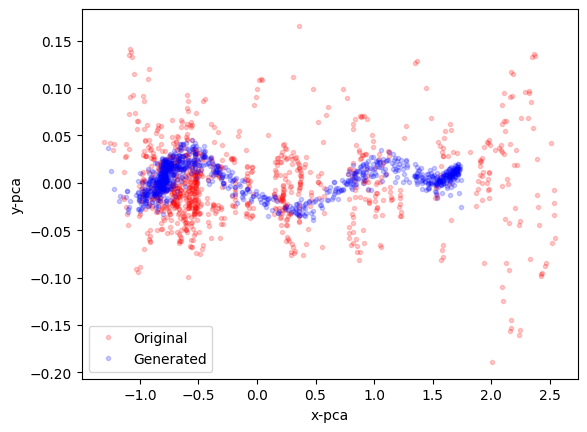

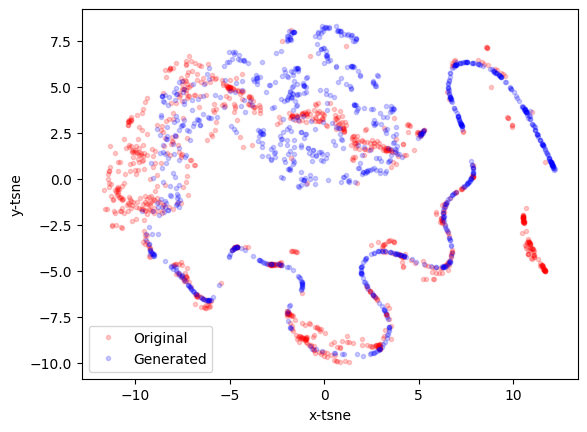

In [27]:
# Plot real and generated distributions
plot_distribution_estimate(*low_dimensional_representation(data_train, data_gen, 'pca'), 'pca')
plot_distribution_estimate(*low_dimensional_representation(data_train, data_gen, 'tsne'), 'tsne')